In [1]:
!pip install opencv-python --trusted-host mirrors.intra.didiyun.com --index-url http://mirrors.intra.didiyun.com/pip/simple 

Looking in indexes: http://mirrors.intra.didiyun.com/pip/simple
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
import os
import csv # noqa
import json
import struct
import io
import numpy as np
import requests
import time
import cv2
import base64
import random
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Markdown, display, HTML, IFrame
from pprint import pprint
from random import sample
from urllib.request import urlretrieve
from k12libs.utils.nb_easy import k12ai_get_top_dir, RACEURL
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT

In [3]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

In [4]:
API_INFERENCE = f'{RACEURL}/raceai/framework/inference'
API_INFERENCE

'http://116.85.5.40:9119/raceai/framework/inference'

In [5]:
API_POPMSG = f'{RACEURL}/raceai/private/popmsg'
API_POPMSG 

'http://116.85.5.40:9119/raceai/private/popmsg'

In [6]:
reqdata = '''{
    "task": "zmq.yolo.inference",
    "cfg": {
        "pigeon": {
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": [
                    "val/face_197.jpeg",
                    "val/face_226.jpeg"
                ],
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "/raceai/data/datasets/faces/images/"
                    }
                }
            }
        }
    }
}'''

### 输入

只需要修改: `data_source` 和 `data_prefix`

In [7]:
print(reqdata)

{
    "task": "zmq.yolo.inference",
    "cfg": {
        "pigeon": {
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": [
                    "val/face_197.jpeg",
                    "val/face_226.jpeg"
                ],
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "/raceai/data/datasets/faces/images/"
                    }
                }
            }
        }
    }
}


In [8]:
resdata = json.loads(requests.post(url=API_INFERENCE, json=json.loads(reqdata)).text)
time.sleep(3)

### 输出

redis key: `zmq.yolo.inference.result`

通过判断`faces_det`里面有多少个json对象, 每个json对象表示图片中的一个脸, 其中conf表示人脸的置信度, xyxy表示标注人脸的矩形框

```
{
    "pigeon": {
        "user": "1", 
        "uuid": "100"
    }, 
    "task": "zmq.yolo.inference", 
    "errno": 0, 
    "result": [
        {
            "image_path": "/raceai/data/datasets/faces/images/val/face_197.jpeg", 
            "faces_det": [
                {
                    "conf": "0.571", 
                    "xyxy": [
                        8, 
                        1, 
                        275, 
                        264
                    ]
                }, 
                {
                    "conf": "0.667", 
                    "xyxy": [
                        268, 
                        90, 
                        403, 
                        325
                    ]
                }, 
                {
                    "conf": "0.859", 
                    "xyxy": [
                        0, 
                        111, 
                        299, 
                        328
                    ]
                }, 
                {
                    "conf": "0.892", 
                    "xyxy": [
                        290, 
                        102, 
                        612, 
                        331
                    ]
                }
            ]
        }, 
        {
            "image_path": "/raceai/data/datasets/faces/images/val/face_226.jpeg", 
            "faces_det": [
                {
                    "conf": "0.385", 
                    "xyxy": [
                        2228, 
                        624, 
                        3117, 
                        1464
                    ]
                }, 
                {
                    "conf": "0.703", 
                    "xyxy": [
                        1241, 
                        826, 
                        3321, 
                        3000
                    ]
                }, 
                {
                    "conf": "0.854", 
                    "xyxy": [
                        2488, 
                        744, 
                        4137, 
                        3013
                    ]
                }, 
                {
                    "conf": "0.909", 
                    "xyxy": [
                        3769, 
                        739, 
                        5616, 
                        2284
                    ]
                }, 
                {
                    "conf": "0.913", 
                    "xyxy": [
                        216, 
                        1389, 
                        1746, 
                        2969
                    ]
                }, 
                {
                    "conf": "0.928", 
                    "xyxy": [
                        4036, 
                        1365, 
                        5511, 
                        3107
                    ]
                }
            ]
        }
    ]
}
```

## 单张Base64

In [9]:
test_face1 = '/hzcsk12/hzcsnote/assets/images/face_0.jpeg'
test_image1 = cv2.cvtColor(cv2.imread(test_face1), cv2.COLOR_BGR2RGB)

def img2b64(path):
    with open(path, 'rb') as fr:
        b4data = base64.b64encode(fr.read()).decode()
    return b4data

reqdata = '''{
    "task": "zmq.yolo.inference",
    "cfg": {
        "pigeon": {
            "msgkey": "zmq.yolo.test",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.Base64DataLoader",
            "params": {
                "data_source": "%s",
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {}
                }
            }
        },
        "nms":{
            "conf_thres": 0.25,
            "iou_thres": 0.45
        }
    }
}''' % img2b64(test_face1)

# eval(reqdata)

json.loads(requests.get(url=f'{API_POPMSG}?key=zmq.yolo.test').text)
resdata = json.loads(requests.post(url=API_INFERENCE, json=json.loads(reqdata)).text)
time.sleep(3)

[{'pigeon': {'msgkey': 'zmq.yolo.test', 'user': '1', 'uuid': '100'}, 'task': 'zmq.yolo.inference', 'errno': 0, 'result': [{'image_path': '/tmp/b4img_1612455687.png', 'faces_det': [{'conf': '0.334', 'xyxy': [57, 101, 104, 144]}, {'conf': '0.435', 'xyxy': [366, 75, 434, 155]}]}], 'running_time': 0.2616419792175293}]


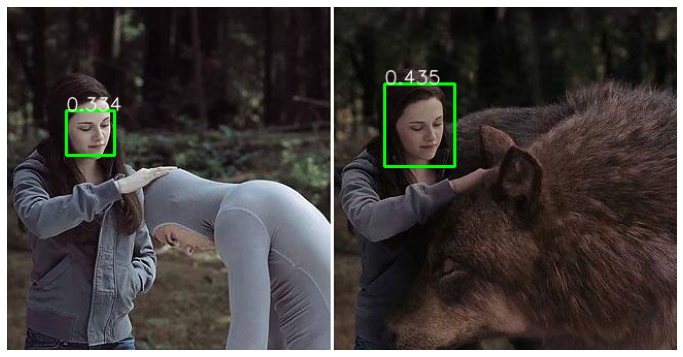

In [10]:
resdata = json.loads(requests.get(url=f'{API_POPMSG}?key=zmq.yolo.test').text)
print(resdata)
for data in resdata:
    faces_det = data['result'][0]['faces_det']
    for item in faces_det:
        xyxy = tuple(item['xyxy'])
        cv2.rectangle(test_image1, xyxy[0:2], xyxy[2:], (0, 255, 0), 2)
        cv2.putText(test_image1, item['conf'], xyxy[0:2], 0, 0.6, (255, 255, 255), lineType=cv2.LINE_AA)

        
plt.figure(figsize=(12, 8))
plt.imshow(test_image1)
plt.axis('off');

## 批量探测

In [11]:
import random

with open('/data/datasets/cv/casia_facev5/files.txt', 'r') as fr:
    facesfiles = fr.read().split('\n')

image_files = random.choices(facesfiles, k=20)

reqdata = '''{
    "task": "zmq.yolo.inference",
    "cfg": {
        "pigeon": {
            "msgkey": "zmq.yolo.test",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": %s,
                "dataset": {
                    "class_name": "raceai.data.RawRaceDataset",
                    "params": {
                        "data_prefix": "/raceai/data/datasets/casia_facev5"
                    }
                }
            }
        },
        "nms":{
            "conf_thres": 0.25,
            "iou_thres": 0.45
        }
    }
}''' % (json.dumps(image_files))

eval(reqdata)

json.loads(requests.get(url=f'{API_POPMSG}?key=zmq.yolo.test').text)
json.loads(requests.post(url=API_INFERENCE, json=json.loads(reqdata)).text)
time.sleep(5)

[{'pigeon': {'msgkey': 'zmq.yolo.test', 'user': '1', 'uuid': '100'}, 'task': 'zmq.yolo.inference', 'errno': 0, 'result': [{'image_path': '/raceai/data/datasets/casia_facev5/001/001_3.bmp', 'faces_det': [{'conf': '0.319', 'xyxy': [228, 110, 390, 275]}]}, {'image_path': '/raceai/data/datasets/casia_facev5/028/028_1.bmp', 'faces_det': [{'conf': '0.474', 'xyxy': [294, 135, 404, 256]}]}, {'image_path': '/raceai/data/datasets/casia_facev5/019/019_4.bmp', 'faces_det': [{'conf': '0.462', 'xyxy': [374, 186, 540, 377]}]}, {'image_path': '/raceai/data/datasets/casia_facev5/076/076_0.bmp', 'faces_det': [{'conf': '0.270', 'xyxy': [279, 145, 380, 242]}]}, {'image_path': '/raceai/data/datasets/casia_facev5/093/093_3.bmp', 'faces_det': [{'conf': '0.449', 'xyxy': [295, 127, 399, 244]}]}, {'image_path': '/raceai/data/datasets/casia_facev5/066/066_2.bmp', 'faces_det': [{'conf': '0.430', 'xyxy': [282, 151, 388, 266]}]}, {'image_path': '/raceai/data/datasets/casia_facev5/048/048_0.bmp', 'faces_det': [{'con

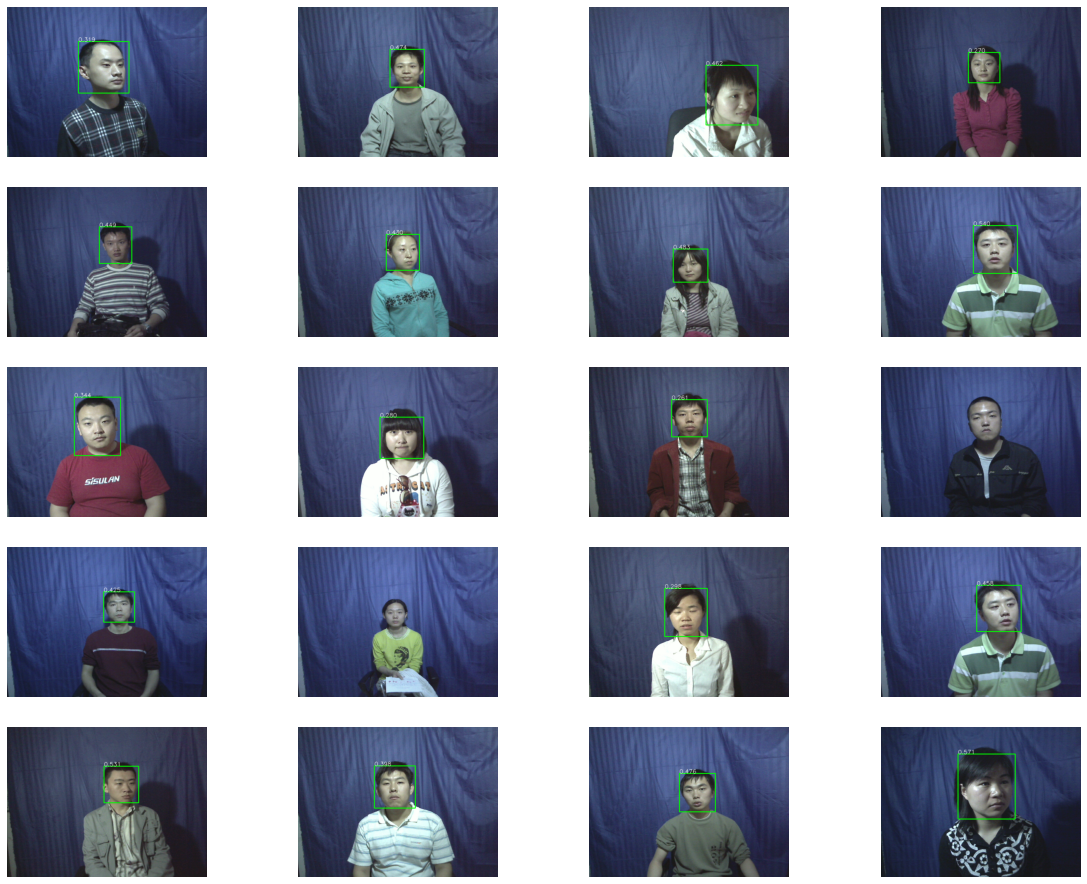

In [12]:
plt.figure(figsize=(20, 16))
resdata = json.loads(requests.get(url=f'{API_POPMSG}?key=zmq.yolo.test').text)
print(resdata)
for data in resdata:
    for i, result in enumerate(data['result']):
        image_path = '/'.join(result['image_path'].split('/')[-2:])
        image_path = f'/data/datasets/cv/casia_facev5/{image_path}'
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        for item in result['faces_det']:
            xyxy = tuple(item['xyxy'])
            cv2.rectangle(image, xyxy[0:2], xyxy[2:], (0, 255, 0), 2)
            cv2.putText(image, item['conf'], xyxy[0:2], 0, 0.6, (255, 255, 255), lineType=cv2.LINE_AA)
        plt.subplot(5, 4, i+1)
        plt.imshow(image)
        plt.axis('off');

## References

- [人脸数据集](https://www.geticsen.cn/Index/article/content/230.html)